In [1]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [2]:
points = np.load("Parabola.Points.1000.npy")
labels = np.load("Parabola.Labels.1000.npy")

In [3]:
#print(points)
#print(labels)
#print(points[:-100,:].shape)

# Number of support vectors:
| C        | Gamma    | Number of Support Vectors | Accuracy | Comments |
|----------|----------|---------------------------|----------|----------|
|1         | 0.01     | 189                       | 0.98     |          |
|100       | 0.01     | 102                       | 0.98     |          |
|1         | 0.001    | 155                       | 0.99     |          |
|100       | 0.001    | 37                        | 1.00     | BEST     |
|1         | 0.0001   | 378                       | 0.88     |          |
|100       | 0.0001   | 108                       | 1.00     |          |

In [4]:
clf = SVC(C=100, gamma=0.001)
print(clf)
clf.fit(points[:-100,:], labels[:-100])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [5]:
numcorrect = 0
for (point, label) in zip(points[-100:,:], labels[-100:]):
    prediction = clf.predict([point])
#    print("Point: " + str(point) + " Label: " + str(label) + " Prediction: " + str(prediction))
    if label == prediction:
        numcorrect += 1
    else:
        print("INACCURATE PREDICTION!!: Point: " + str(point) + " Label: " + str(label) + " Prediction: " + str(prediction))
print("Accuracy: " + str(float(numcorrect)/100.0))

Accuracy: 1.0


In [6]:
#print(clf.support_.shape)

In [7]:
print(str(clf.support_vectors_.shape))

(37, 2)


In [8]:
prediction_at_support = np.empty(clf.support_vectors_.shape[0])
i = 0
for (x, y) in clf.support_vectors_:
    prediction_at_support[i] = clf.predict([[x,y]])
    i += 1
print(prediction_at_support.shape)
#print(prediction_at_support)

(37,)


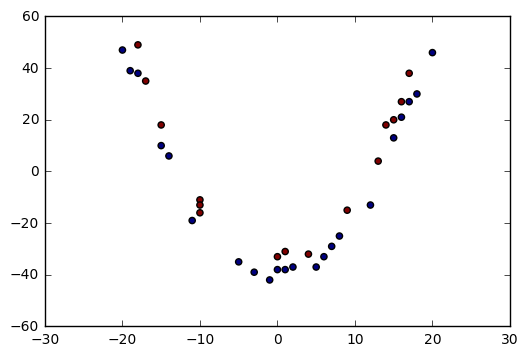

In [9]:
plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c=prediction_at_support[:] )
plt.show()